In [ ]:
pip install torch matplotlib

In [1]:
import torch
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt

# EDA

In [2]:
words = open("D:/DeepLearning/Pytorch/names.txt").read().splitlines()
print(words[:10])
random.seed(2147483647)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
print(words[:10], n1, n2)

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']
['khole', 'harbour', 'devon', 'baine', 'erisha', 'ivani', 'hollyn', 'kristell', 'zyva', 'ella'] 25626 28829


In [3]:
len(words)

32033

In [4]:
chars = []
for w in words:
    chars += list(w)
chars = sorted(set(chars))
chars

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

# Dataset Preprocessing

In [5]:
#vocab
stoi = {ch : i+1 for i, ch in enumerate(chars)}
itos = {i+1 : ch for i, ch in enumerate(chars)}
stoi['.'] = 0
itos[0] = '.' 

In [6]:
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [7]:
def build_dataset(words, block_size, stoi = stoi, itos = itos):
    X = []
    y = []
    for w in words:
        w += '.'
        context = [0] * block_size
        for ch in w:
            ix = stoi[ch]
            X.append(context)
            y.append(ix)
            context = context[1:] + [ix]
    return torch.tensor(X), torch.tensor(y)
        

block_size = 3
Xtr, ytr = build_dataset(words[:n1], block_size)
Xval, yval = build_dataset(words[n1:n2], block_size)
Xtest, ytest = build_dataset(words[n2:], block_size)

In [8]:
print(Xtr.shape, ytr.shape, Xval.shape, yval.shape, Xtest.shape, ytest.shape)

torch.Size([182546, 3]) torch.Size([182546]) torch.Size([22840, 3]) torch.Size([22840]) torch.Size([22760, 3]) torch.Size([22760])


# Model Building

In [667]:
#lr
lre = torch.linspace(-3, 0, (1000))
lr = 10**lre
print(lr) 
print(lr.shape)

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [666]:
#Embedder
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator = g)
C[:3]

tensor([[ 1.5674, -0.2373],
        [-0.0274, -1.1008],
        [ 0.2859, -0.0296]])

In [711]:
#parameters
g = torch.Generator().manual_seed(2147483647)
w1 = torch.randn((6, 100), requires_grad = True, generator = g)
b1 = torch.randn(100, requires_grad = True, generator = g)
w2 = torch.randn((100, 30), requires_grad = True, generator = g)
b2 = torch.randn(30, requires_grad = True, generator = g)
w3 = torch.randn((30, 27), requires_grad = True, generator = g)
parameters = [w1, b1, w2, b2, w3]
print("Total Parameters: ", sum([p.nelement() for p in parameters]))

Total Parameters:  4540


In [735]:
#Train
#layer = 3
#lr_ls = []
loss_ls = []
step_ls = []
i = 0
while True:
#for i in range(10000):
    #Create mini batches
    ix = torch.randint(0, Xtr.shape[0], (32, ))
    
    #Forward
    emb = C[Xtr[ix]]
    emb = emb.view(-1, emb.shape[1] * emb.shape[-1])
    h =  torch.tanh(emb @ w1 + b1)
    logits = h @ w2 + b2
    logits = logits @ w3
    loss = F.cross_entropy(logits, ytr[ix])
    #if i%10 == 0:
        #print(loss)

    #Backward
    for p in parameters:
        p.grad = None
    loss.backward()

    #Update
    for p in parameters:
       p.data += -0.01 * p.grad

    #Track stats
    #lr_ls.append(lre[i].item())
    loss_ls.append(loss.item())
    step_ls.append(i)
    i += 1
    if sum(loss_ls)/float(len(loss_ls)) < 2.3:
        break
print(sum(loss_ls)/float(len(loss_ls)))

2.272214412689209


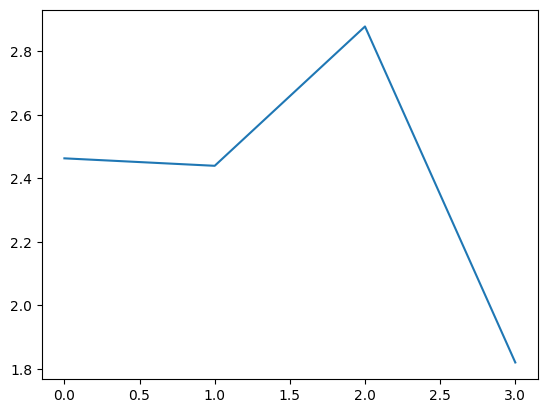

In [730]:
plt.plot(step_ls, loss_ls)

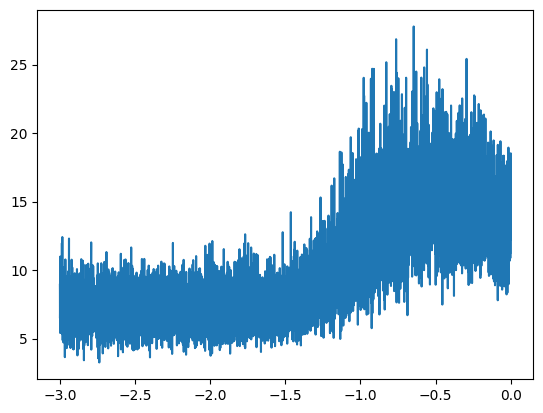

In [376]:
plt.plot(lr_ls, loss_ls)

In [717]:
10**-2.8

0.001584893192461114

In [551]:
train_loss = []
val_loss = []

In [738]:
print(train_loss, val_loss)

[3.584317684173584, 3.5842983722686768, 3.327155113220215, 3.3263580799102783, 2.3915600776672363, 2.3864357471466064, 2.338571548461914, 2.3477540016174316, 2.264305353164673] [3.6197457313537598, 3.619720697402954, 3.3595573902130127, 3.358657121658325, 2.407165288925171, 2.4015424251556396, 2.354567050933838, 2.3652303218841553, 2.2869210243225098]


In [736]:
#Evaluation on entire train test
emb = C[Xtr]
emb = emb.view(-1, emb.shape[1] * emb.shape[-1])
h =  torch.tanh(emb @ w1 + b1)
logits = h @ w2 + b2
logits = logits @ w3
loss = F.cross_entropy(logits, ytr)
print(loss.item())
train_loss.append(loss.item())

2.264305353164673


In [737]:
#Evaluation on val set
emb = C[Xval]
emb = emb.view(-1, emb.shape[1] * emb.shape[-1])
h =  torch.tanh(emb @ w1 + b1)
logits = h @ w2 + b2
logits = logits @ w3
loss = F.cross_entropy(logits, yval)
print(loss.item())
val_loss.append(loss.item())

2.2869210243225098


In [739]:
#inference
g = torch.Generator().manual_seed(2147483647)
def forward(X, name):
    emb = C[X]
    emb = emb.view(emb.shape[0] * emb.shape[-1])
    h =  torch.tanh(emb @ w1 + b1)
    logits = h @ w2 + b2
    logits = logits @ w3
    softmax = F.softmax(logits, dim = -1)
    ix = torch.multinomial(softmax, num_samples = 1, generator = g)
    predicted = itos[ix.item()]
    name += predicted
    if predicted == '.':
        print(name)
        return
    X = torch.cat((X[1:], ix))
    forward(X, name)

for i in range(20):
    X = torch.tensor([0,0,0])
    forward(X, "")

junide.
jana.
adha.
cory.
adin.
kohin.
toleigh.
gee.
kalinaa.
yanilenias.
dedainroy.
bresson.
evyla.
terindelmekif.
demmy.
ponis.
jahrian.
reore.
yaenon.
kaenaed.
